In [1]:
#!pip install scikit-learn

In [2]:
#!pip install shapely

In [3]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import resnet18
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt 

In [4]:
class DisasterTypeDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (string): Directory with all post-disaster images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]  # Filter out directories
        self.label_encoder = LabelEncoder()
        disaster_types = [self.extract_disaster_type(f) for f in self.image_filenames]
        self.labels = self.label_encoder.fit_transform(disaster_types)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

    def extract_disaster_type(self, filename):
        parts = filename.split('_')
        first_part = parts[0]
        disaster_types = ["hurricane", "fire", "wind", "flooding", "tsunami", "earthquake"] # There is no wind in data, but web page said there is
        for disaster_type in disaster_types:
            if disaster_type in first_part:
                return disaster_type
        return "unknown"

    def get_disaster_types(self):
        return self.label_encoder.classes_



In [5]:
# Add more transformations methods (e.g. random rotations, flips, and color adjustments)
def get_augmented_transform():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def distillation_loss(student_outputs, teacher_outputs, labels, T=2.0, alpha=0.7, weight_loss_factor=0.5):
    soft_loss = nn.KLDivLoss()(F.log_softmax(student_outputs/T, dim=1),
                               F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    hard_loss = F.cross_entropy(student_outputs, labels) * (1. - alpha)
    weight_tensor = torch.full((6,), weight_loss_factor, device=student_outputs.device)  # Assuming 6 classes
    weight_loss = F.cross_entropy(student_outputs, labels, weight=weight_tensor)

    return soft_loss + hard_loss + weight_loss



In [6]:
class CNN_model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x.float()))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = x.view(-1, 512 * 16 * 16)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
# plotting the loss
def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [8]:
# Define the training function
def train_model(model, teacher_model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    teacher_model = teacher_model.to(device)
    teacher_model.eval()
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

    # add loss
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            student_outputs = model(images)
            teacher_outputs = teacher_model(images)
            loss = distillation_loss(student_outputs, teacher_outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_losses.append(loss.item())
            
            _, predicted = torch.max(student_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%')

        scheduler.step()

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        val_losses.append(val_loss / len(val_loader))

        val_acc = 100 * correct / total
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_acc:.2f}%')

    print("Finished Training")
    plot_loss(train_losses, val_losses)

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1/10, Loss: 0.8697, Accuracy: 82.67%
Validation Loss: 0.3639, Accuracy: 88.95%
Epoch 2/10, Loss: 0.6428, Accuracy: 89.68%
Validation Loss: 0.3259, Accuracy: 91.35%
Epoch 3/10, Loss: 0.5861, Accuracy: 91.40%
Validation Loss: 0.3905, Accuracy: 88.65%
Epoch 4/10, Loss: 0.4471, Accuracy: 96.17%
Validation Loss: 0.1650, Accuracy: 96.80%
Epoch 5/10, Loss: 0.4154, Accuracy: 97.10%
Validation Loss: 0.1415, Accuracy: 97.24%
Epoch 6/10, Loss: 0.3998, Accuracy: 97.63%
Validation Loss: 0.1453, Accuracy: 97.67%
Epoch 7/10, Loss: 0.3941, Accuracy: 97.79%
Validation Loss: 0.1352, Accuracy: 97.89%
Epoch 8/10, Loss: 0.3850, Accuracy: 97.97%
Validation Loss: 0.1347, Accuracy: 97.96%
Epoch 9/10, Loss: 0.3863, Accuracy: 98.11%
Validation Loss: 0.1362, Accuracy: 98.04%
Epoch 10/10, Loss: 0.3825, Accuracy: 98.21%
Validation Loss: 0.1285, Accuracy: 98.11%
Finished Training


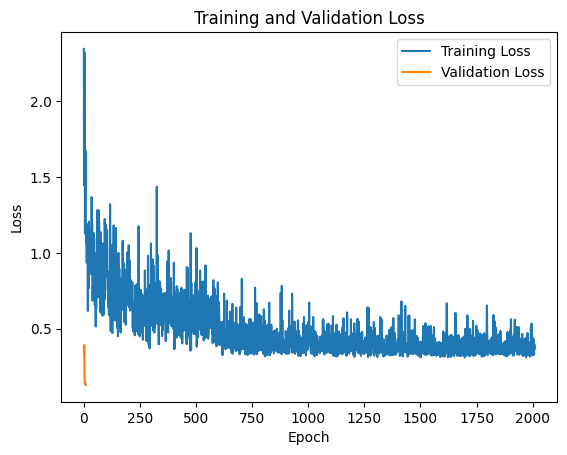

In [9]:
# Main function
def main():
    image_dir = 'post_disaster'
    transform = get_augmented_transform()
    dataset = DisasterTypeDataset(image_dir, transform=transform)
    num_classes = len(set(dataset.labels))

    train_set, val_set, test_set = random_split(dataset, [int(0.7 * len(dataset)),
                                                           int(0.15 * len(dataset)),
                                                           len(dataset) - int(0.7 * len(dataset)) - int(0.15 * len(dataset))])

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

    teacher_model = resnet18(pretrained=True)
    teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)

    student_model = CNN_model(num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
    optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)

    train_model(teacher_model, student_model, train_loader, val_loader, criterion, optimizer_teacher, 10)
    
    # Output the trained student model
    torch.save(student_model.state_dict(), 'trained_student_model.pth')

if __name__ == '__main__':
    main()